In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import io
import requests

In [2]:
url_total  = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

In [3]:
def covid_country(country = 'Total', url = url_total):
    df = pd.read_csv(url)
    df.rename(columns={"Country/Region" : "Country", "Province/State" : "Province"}, inplace=True)
    if country == 'Total':
        return df
    else:
        df_country = df[df['Country'].str.match(country)]
        return df_country
    
def get_cases(df_country, period = '1/22/20'):
    return df_country.loc[:, '1/22/20':].values[0]

df_Ch = covid_country('Mainland China', url_total)
df_Ch = df_Ch.sum(numeric_only=True)
cases_china = df_Ch[2:].values

df_Ch_dead = covid_country('Mainland China', url_deaths)
df_Ch_dead = df_Ch_dead.sum(numeric_only=True)
deaths_china = df_Ch_dead[2:].values

df_Ch_reco = covid_country('Mainland China', url_deaths)
df_Ch_reco = df_Ch_reco.sum(numeric_only=True)
recovs_china = df_Ch_reco[2:].values

time = range(len(cases_china))

best fitted parameters (M,k,x0) : 
[8.07557508e+04 2.22604536e-01 1.77441254e+01]
covariance matrix : 
[[ 3.88852578e+05 -2.47999892e+00  6.45997909e+01]
 [-2.47999892e+00  6.06968381e-05 -4.08520431e-04]
 [ 6.45997909e+01 -4.08520431e-04  3.39968151e-02]]
fitted M = 80755.7508 +- 623.5805 
fitted k = 0.2226 +- 0.0078 
fitted x0 = 17.7441 +- 0.1844 


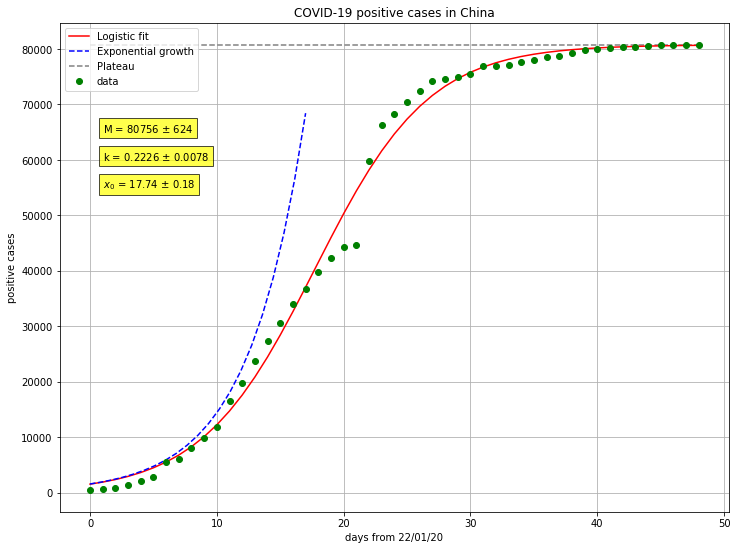

In [21]:
def f(x, M, k, x0):
    return M/(1 + np.exp(-k*(x-x0)))

def g(x, M, k, x0):
    return M*np.exp(k*(x-x0))

initial_guess = (80000, 0.1, 20)
upbound       = [90000, 1, 50]
lowbound      = [70000,0,0]

#sigma=np.array([np.sqrt(x) for x in n])
popt, pcov = curve_fit(f,time,cases_china,p0=initial_guess,bounds=[lowbound,upbound])
#popt, pcov = optimize.curve_fit(Gaussian,bins20,binData20,sigma=sigma)

print('best fitted parameters (M,k,x0) : ')
print(popt)
print('covariance matrix : ')
print(pcov)

#To get parameters uncertainties we take the square root from diagonal elements of the covariance matrix
print('fitted M = %.4f +- %.4f ' %(popt[0],np.sqrt(np.diag(pcov)[0])) )
print('fitted k = %.4f +- %.4f ' %(popt[1],np.sqrt(np.diag(pcov)[1])) )
print('fitted x0 = %.4f +- %.4f ' %(popt[2],np.sqrt(np.diag(pcov)[2])) )

fitted_M = [popt[0],np.sqrt(np.diag(pcov)[0])]
fitted_k = [popt[1],np.sqrt(np.diag(pcov)[1])]
fitted_x0 = [popt[2],np.sqrt(np.diag(pcov)[2])]

plt.figure(figsize=[12,9])
plt.errorbar(time, cases_china,fmt='o',ecolor='g',c='g',label="data")
plt.plot(time,f(time,fitted_M[0],fitted_k[0],fitted_x0[0]),'r',label='Logistic fit')
time_truncated = np.linspace(0,17, 21)
plt.plot(time_truncated,g(time_truncated,fitted_M[0],fitted_k[0],fitted_x0[0]),'b',linestyle='--',label='Exponential growth')
plt.hlines(fitted_M[0], 0, time[-1], colors='grey', linestyle='--', label='Plateau')
plt.legend(loc="upper left")
plt.grid()
plt.xlabel('days from 22/01/20')
plt.ylabel('positive cases')
plt.title('COVID-19 positive cases in China')
#plt.text(1, 50000, r'1/(1 + exp(-k(x-x0)))' % (fitted_M[0], fitted_M[1]), bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(1, 65000, r'M = %1.0f $\pm$ %1.0f' % (fitted_M[0], fitted_M[1]), bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(1, 60000, r'k = %1.4f $\pm$ %1.4f' % (fitted_k[0], fitted_k[1]), bbox=dict(facecolor='yellow', alpha=0.7))
plt.text(1, 55000, r'$x_0$ = %1.2f $\pm$ %1.2f' % (fitted_x0[0], fitted_x0[1]), bbox=dict(facecolor='yellow', alpha=0.7))
plt.show()